In [26]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

'''import kagglehub
borismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')
print('Data source import complete.')'''

"import kagglehub\nborismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')\nprint('Data source import complete.')"

### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [27]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import yfinance as yf
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

import FinanceDataReader as fdr
from datetime import datetime
from alpha_code_1 import get_alpha
from sklearn.preprocessing import StandardScaler


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [72]:
import FinanceDataReader as fdr

start_date = '2001-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

# 다음날 종가가 오늘보다 높으면 1 (상승), 아니면 0 (하락)
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df = get_alpha(df)

# 마지막 row는 타겟이 없으므로 제거
df = df.iloc[:-1]

In [73]:
# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 2. 정규화 (표준화: 평균 0, 표준편차 1)
def normalize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index, columns=df.columns)

# 3. 이산형 / 연속형 분리
def separate_discrete_continuous(df, threshold=10):
    discrete_features = []
    continuous_features = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values <= threshold:
            discrete_features.append(col)
        else:
            continuous_features.append(col)
    return discrete_features, continuous_features

# 4. 중복 feature 제거 (feature 값이 거의 비슷한 경우 제거)
def remove_duplicate_features(df, duplicate_threshold=0.2):
    to_remove = []
    for col in df.columns:
        freq = df[col].value_counts(normalize=True).max()
        if freq > duplicate_threshold:
            to_remove.append(col)
    df_cleaned = df.drop(columns=to_remove)
    return df_cleaned, to_remove


# 5. 전체 파이프라인 함수
def clean_features(df):
    print("원본 feature 수:", df.shape[1])

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 중복 feature 제거
    df_cleaned, removed_features = remove_duplicate_features(df)
    print(f"중복 feature 제거 완료 (제거한 feature 수: {len(removed_features)})")

    print("최종 feature 수:", df_cleaned.shape[1])
    return df_cleaned, discrete_features, continuous_features, removed_features

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas_only = df[alpha_cols]

# 파이프라인 적용
df_cleaned, discrete_features, continuous_features, removed_features = clean_features(df_alphas_only)

df_cleaned['S_DQ_CLOSE'] = df['S_DQ_CLOSE']
df_cleaned['target'] = df['target']
df = df_cleaned.copy()

원본 feature 수: 82
결측값 채우기 완료
중복 feature 제거 완료 (제거한 feature 수: 23)
최종 feature 수: 59


### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [74]:
df['EMA_9'] = df['S_DQ_CLOSE'].ewm(9).mean().shift()
df['SMA_5'] = df['S_DQ_CLOSE'].rolling(5).mean().shift()
df['SMA_10'] = df['S_DQ_CLOSE'].rolling(10).mean().shift()
df['SMA_15'] = df['S_DQ_CLOSE'].rolling(15).mean().shift()
df['SMA_30'] = df['S_DQ_CLOSE'].rolling(30).mean().shift()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [76]:
def relative_strength_idx(df, n=14):
    close = df['S_DQ_CLOSE']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

#### MACD

In [77]:
EMA_12 = pd.Series(df['S_DQ_CLOSE'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['S_DQ_CLOSE'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [78]:
df = df.iloc[33:] # Because of moving averages and MACD line
df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [79]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

### Drop unnecessary columns

### Split into features and labels

In [80]:
y_train = train_df['target'].copy()
X_train = train_df.drop(columns=['S_DQ_CLOSE', 'target'])

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(columns=['S_DQ_CLOSE', 'target'])

y_test  = test_df['target'].copy()
X_test  = test_df.drop(columns=['S_DQ_CLOSE', 'target'])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3437 entries, 0 to 3436
Data columns (total 67 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alpha002     3437 non-null   float64
 1   alpha003     3437 non-null   float64
 2   alpha005     3437 non-null   float64
 3   alpha006     3437 non-null   float64
 4   alpha008     3437 non-null   float64
 5   alpha009     3437 non-null   float64
 6   alpha010     3437 non-null   float64
 7   alpha011     3437 non-null   float64
 8   alpha012     3437 non-null   float64
 9   alpha013     3437 non-null   float64
 10  alpha014     3437 non-null   float64
 11  alpha015     3437 non-null   float64
 12  alpha016     3437 non-null   float64
 13  alpha017     3437 non-null   float64
 14  alpha018     3437 non-null   float64
 15  alpha019     3437 non-null   float64
 16  alpha020     3437 non-null   float64
 17  alpha022     3437 non-null   float64
 18  alpha024     3437 non-null   float64
 19  alpha0

### Fine-tune XGBoostRegressor

In [62]:
%%time
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8, 10],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
clf = GridSearchCV(model, parameters, scoring='accuracy', cv=tscv)
clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation accuracy = {clf.best_score_:.4f}')

c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:50:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:50:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:50:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:50:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:50:12] WARNING: C:\actions-runner\_work\xgboost\xgboos

Best params: {'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100, 'random_state': 42}
Best validation accuracy = 0.5129
CPU times: total: 17min 27s
Wall time: 1min 29s


In [81]:
%%time
model = xgb.XGBClassifier(
    **clf.best_params_,
    objective='binary:logistic',
    use_label_encoder=False,  # 경고 방지
    eval_metric='logloss'     # 또는 'error', 'auc' 등 선택 가능
)

model.fit(X_train, y_train)

c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:56:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




CPU times: total: 7.95 s
Wall time: 759 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.01,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

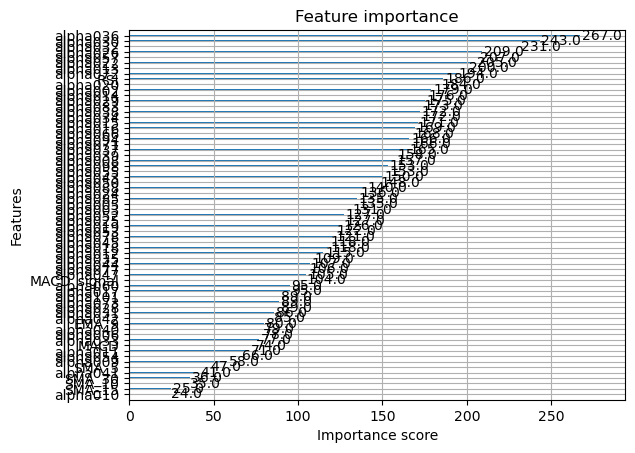

In [82]:
plot_importance(model);

### Calculate and visualize predictions

In [83]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [0 1 1 0 0]
y_pred = [0 1 0 0 1]


In [84]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.48233695652173914
              precision    recall  f1-score   support

           0       0.44      0.66      0.53       324
           1       0.56      0.34      0.43       412

    accuracy                           0.48       736
   macro avg       0.50      0.50      0.48       736
weighted avg       0.51      0.48      0.47       736

Confusion Matrix:
 [[214 110]
 [271 141]]


Threshold=0.450 | Precision(1)=0.572 | Recall(1)=0.575 | Precision(0)=0.457 | Recall(0)=0.454 | Accuracy=0.522
Threshold=0.451 | Precision(1)=0.577 | Recall(1)=0.573 | Precision(0)=0.462 | Recall(0)=0.466 | Accuracy=0.526
Threshold=0.452 | Precision(1)=0.577 | Recall(1)=0.570 | Precision(0)=0.462 | Recall(0)=0.469 | Accuracy=0.526
Threshold=0.453 | Precision(1)=0.580 | Recall(1)=0.570 | Precision(0)=0.465 | Recall(0)=0.475 | Accuracy=0.529
Threshold=0.454 | Precision(1)=0.582 | Recall(1)=0.570 | Precision(0)=0.467 | Recall(0)=0.478 | Accuracy=0.530
Threshold=0.455 | Precision(1)=0.575 | Recall(1)=0.556 | Precision(0)=0.459 | Recall(0)=0.478 | Accuracy=0.522
Threshold=0.456 | Precision(1)=0.577 | Recall(1)=0.553 | Precision(0)=0.460 | Recall(0)=0.485 | Accuracy=0.523
Threshold=0.457 | Precision(1)=0.577 | Recall(1)=0.546 | Precision(0)=0.460 | Recall(0)=0.491 | Accuracy=0.522
Threshold=0.458 | Precision(1)=0.576 | Recall(1)=0.544 | Precision(0)=0.458 | Recall(0)=0.491 | Accuracy=0.520
T

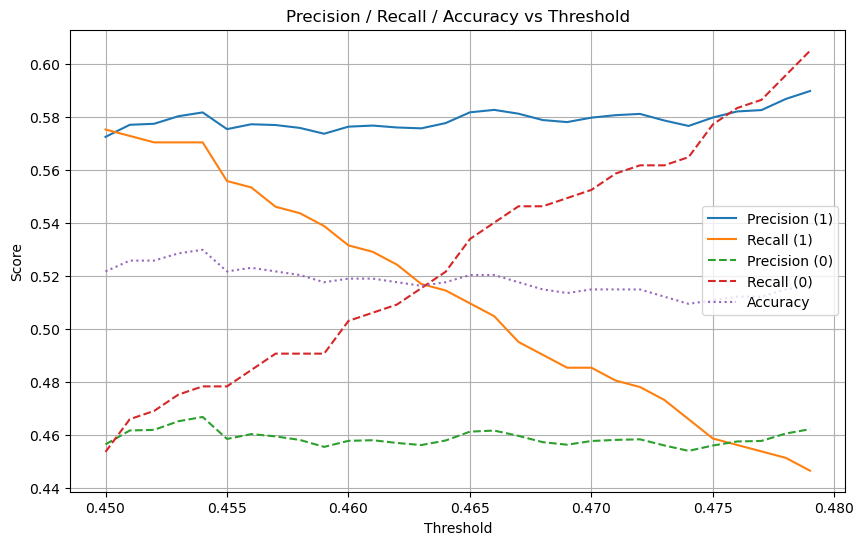

In [86]:
# 1. 확률 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. threshold 리스트
thresholds = np.arange(0.45, 0.48, 0.001)

# 3. 저장할 리스트
precision_1_list = []
recall_1_list = []
precision_0_list = []
recall_0_list = []
accuracy_list = []

# 4. 각 threshold에 대해 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
    recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
    precision_0 = precision_score(y_test, y_pred_custom, pos_label=0)
    recall_0 = recall_score(y_test, y_pred_custom, pos_label=0)
    accuracy = accuracy_score(y_test, y_pred_custom)

    precision_1_list.append(precision_1)
    recall_1_list.append(recall_1)
    precision_0_list.append(precision_0)
    recall_0_list.append(recall_0)
    accuracy_list.append(accuracy)

# 5. 결과 출력
for t, p1, r1, p0, r0, acc in zip(thresholds, precision_1_list, recall_1_list, precision_0_list, recall_0_list, accuracy_list):
    print(f"Threshold={t:.3f} | Precision(1)={p1:.3f} | Recall(1)={r1:.3f} | Precision(0)={p0:.3f} | Recall(0)={r0:.3f} | Accuracy={acc:.3f}")

# 6. 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_1_list, label='Precision (1)', linestyle='-')
plt.plot(thresholds, recall_1_list, label='Recall (1)', linestyle='-')
plt.plot(thresholds, precision_0_list, label='Precision (0)', linestyle='--')
plt.plot(thresholds, recall_0_list, label='Recall (0)', linestyle='--')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

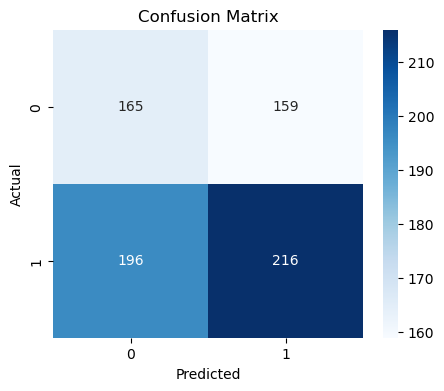

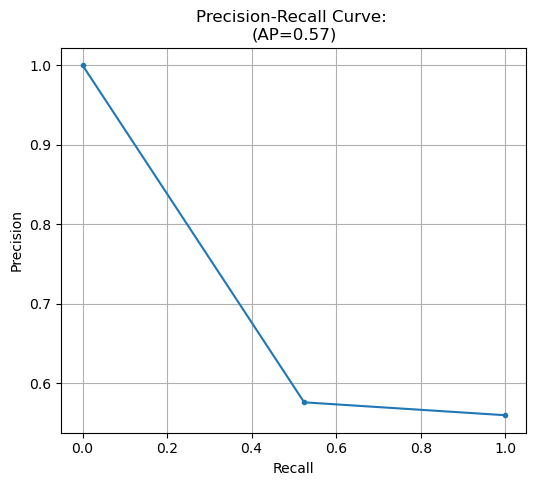

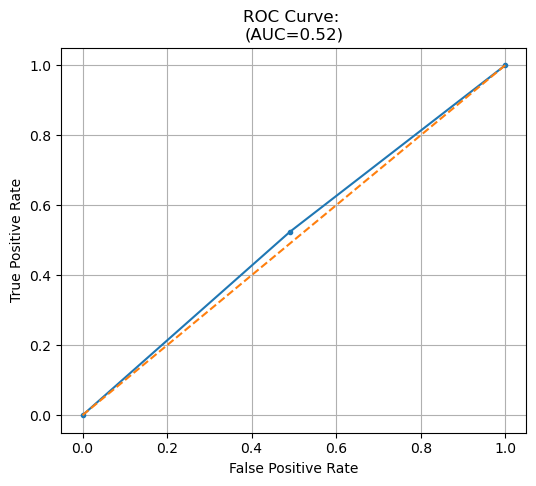


✅ Final Test Accuracy (Threshold = 0.462): 0.5177


In [87]:
#성과 분석 시각화
threshold = 0.462
y_scores = (y_pred_proba >= threshold).astype(int)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test, y_scores)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Precision-Recall Curve 시각화
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker='.')
plt.title(f'Precision-Recall Curve: \n(AP={average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve: \n(AUC={roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 5. 최종 Accuracy 출력
final_accuracy = accuracy_score(y_test, y_scores)
print(f"\n✅ Final Test Accuracy (Threshold = {threshold}): {final_accuracy:.4f}")